In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


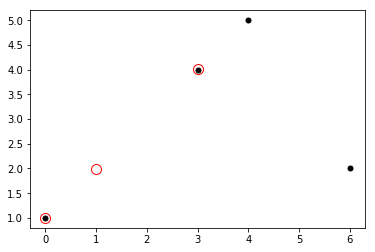

In [2]:
# generate coordinates
x1=np.array([0.,3.,4.,6.])
y1=np.array([1.,4.,5.,2.])
x2=np.array([0.,1.,3.])
y2=np.array([1.,2.,4.])

# add some noise
x2+=np.random.normal(0,.1/60,x2.shape)
y2+=np.random.normal(0,.1/60,y2.shape)

# plot
fig,ax=plt.subplots()

ax.plot(x1,y1,'ok',ms=5)
ax.plot(x2,y2,'or',mfc='none',ms=10)


In [3]:
from astropy import units as u
from astropy.coordinates import SkyCoord

# define coordinates ! with units!

c1 = SkyCoord(ra=x1*u.degree, dec=y1*u.degree) 
c2 = SkyCoord(ra=x2*u.degree, dec=y2*u.degree) 

# and match the two catalogs
idx, d2d, d3d = c2.match_to_catalog_sky(c1) 

`idx` are indices into c1 that are the closest objects to each of the coordinates in c2, `d2d` are the on-sky distances between them, and d3d are the 3-dimensional distances.
Because coordinate objects support indexing, `idx` enables easy access to the matched set of coordinates in the catalog c1

In [4]:
# idx is a list of the indices 
idx

array([0, 0, 1])

In [5]:
# the colsest c1 to each c2 is:
c1[idx]


<SkyCoord (ICRS): (ra, dec) in deg
    [( 0.,  1.), ( 0.,  1.), ( 3.,  4.)]>

In [6]:
# the distance is:
d2d.arcmin


array([  0.09552109,  84.73002655,   0.22362883])

In [7]:
# if you need only the matches within 1arcmin:
cond_matched=d2d.arcmin<1
print (cond_matched)

print (c2[cond_matched])
print (c1[idx][cond_matched])



[ True False  True]
<SkyCoord (ICRS): (ra, dec) in deg
    [(  1.58763929e-03,  0.99987879), (  2.99897547e+00,  4.00358428)]>
<SkyCoord (ICRS): (ra, dec) in deg
    [( 0.,  1.), ( 3.,  4.)]>


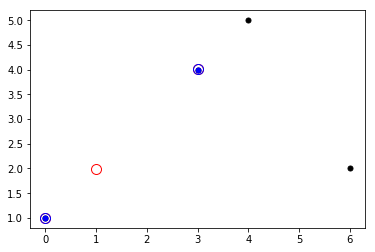

In [8]:

x1OK=x1[idx][cond_matched]
y1OK=y1[idx][cond_matched]

x2OK=x2[cond_matched]
y2OK=y2[cond_matched]
fig,ax=plt.subplots()

ax.plot(x1,y1,'ok',ms=5)
ax.plot(x2,y2,'or',mfc='none',ms=10)
ax.plot(x1OK,y1OK,'ob',ms=5)
ax.plot(x2OK,y2OK,'ob',mfc='none',ms=10)


## Example: select members of NGC188 using proper motion from GAIA DR2
we will use a photometric catalog of stars in the Open Cluster NGC188 from P. Stetson http://apps.canfar.net/storage/list/STETSON/homogeneous/NGC188/

We want to select cluster memebers using GAIA DR2 proper motion

* read NGC188 from local file `NGC188.dat`
* dowload GAIA DR2 from Vizier
* match the two catalogs and select only matches witnin 1 arcsec
* select stars NGC188 members using GAIA proper motion
* plot the color-magnitude diagram of NGC188 members

In [9]:

from astroquery.vizier import Vizier
from astropy import units as u
from astropy.coordinates import SkyCoord

from astropy.io import ascii

## dowload stars from GAIA DR2 within 40 arcmin from the center of NGC 188

In [10]:

# get the center of NGC 188
coo = SkyCoord.from_name('NGC188')
rad=40*u.arcmin

# download from Vizier
cat_id="I/345/gaia2"

v=Vizier(catalog=cat_id,
         columns=["RA_ICRS","DE_ICRS","Plx","pmRA","pmDE"],
        column_filters={'pmRA':'!null','pmDE':'!null'})
# do not download stars with no pmRA and pmDE 
# '!null' is the string that you would put on Vizier


# remove the limit to the number of output objects
v.ROW_LIMIT = -1

tab_gaia = v.query_region(coo, radius=rad,catalog=cat_id)[0]
tab_gaia.info()

<Table masked=True length=15517>
  name   dtype    unit     format                              description                             
------- ------- -------- --------- --------------------------------------------------------------------
RA_ICRS float64      deg {:15.11f}                 Barycentric right ascension (ICRS) at Ep=2015.5 (ra)
DE_ICRS float64      deg {:15.11f}                    Barycentric declination (ICRS) at Ep=2015.5 (dec)
    Plx float64      mas  {:10.4f}                               ? Absolute stellar parallax (parallax)
   pmRA float64 mas / yr   {:9.3f} ? Proper motion in right ascension direction (pmRA*cosDE) (pmra) (3)
   pmDE float64 mas / yr   {:9.3f}                 ? Proper motion in declination direction (pmdec) (4)


<SkyCoord (Galactic): (l, b) in deg
    ( 122.86472547,  22.38364447)>


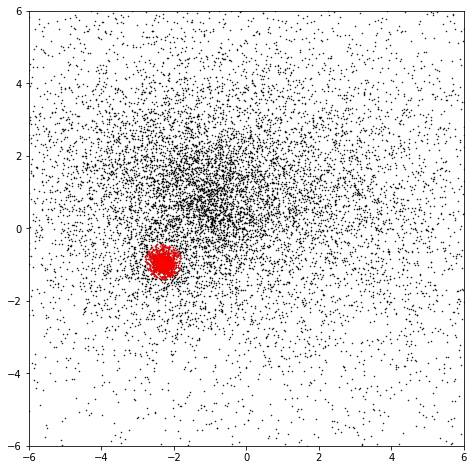

In [11]:
# plot proper motions in RA and DEC and define a member selection criterium
pmRA=tab_gaia["pmRA"]
pmDE=tab_gaia["pmDE"]
fig,ax=plt.subplots(figsize=(8,8))
ax.set_aspect('equal')
ax.plot(pmRA,pmDE,'.k',ms=1)
ax.set_xlim(-6,6)
ax.set_ylim(-6,6)

pmRA0=-2.3 # by eye!!
pmDE0=-0.9 # 
pmdd=.5 #


cond=((pmRA-pmRA0)**2+(pmDE-pmDE0)**2)<pmdd**2

ax.plot(pmRA[cond],pmDE[cond],'.r',ms=1)
print (coo.galactic)

read photometry from `NGC188.dat`. These are the first lines of the file:
```
#ID B V RA DEC
1       20.493  19.356 00:21:13.72 +85:16:36.60
2       17.788  16.986 00:21:10.34 +85:18:40.50
3       18.856  18.183 00:21:03.48 +85:20:29.20
```

In [12]:
tab_phot=ascii.read("NGC188.dat",format="commented_header")
tab_phot


ID,B,V,RA,DEC
int64,float64,float64,str11,str12
1,20.493,19.356,00:21:13.72,+85:16:36.60
2,17.788,16.986,00:21:10.34,+85:18:40.50
3,18.856,18.183,00:21:03.48,+85:20:29.20
4,15.165,14.474,00:21:52.15,+85:12:29.50
5,16.312,15.433,00:21:06.40,+85:20:54.40
6,18.114,17.494,00:21:21.05,+85:18:19.40
7,20.202,19.521,00:21:00.73,+85:22:02.20
8,19.183,18.614,00:21:33.17,+85:16:40.30
9,21.418,20.639,00:21:17.71,+85:19:36.60


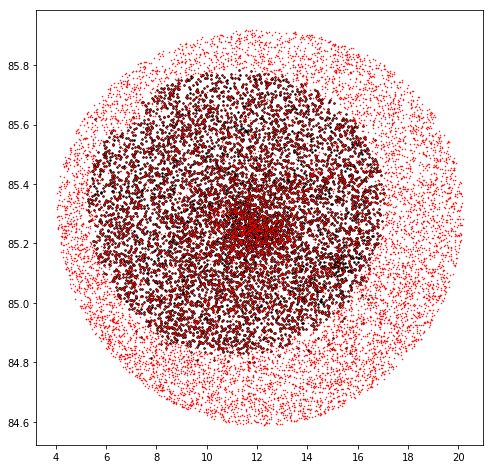

In [13]:
coo_phot=SkyCoord(ra=tab_phot["RA"],dec=tab_phot["DEC"],unit=(u.hourangle, u.deg))

coo_gaia = SkyCoord(tab_gaia['RA_ICRS'], tab_gaia['DE_ICRS'])
# you do not have to give units here, because the GAIA table have units associated with the columns

fig,ax=plt.subplots(figsize=(8,8))
ax.plot(coo_phot.ra,coo_phot.dec,'.k',ms=3)
ax.plot(coo_gaia.ra,coo_gaia.dec,'.r',ms=1)


In [14]:
idx_phot, d2d, d3d = coo_gaia.match_to_catalog_sky(coo_phot)
print (coo_phot.shape)
print (coo_gaia.shape)
print (idx_phot.shape)


(8012,)
(15517,)
(15517,)


In [15]:
# define the selection: only matches within 1 arcsec
cond_matched=d2d.arcsec<1

# select ALL matches (the closest star in tab_phot to EACH GAIA source)
tab_phot_matches=tab_phot[idx_phot]

# apply selection to GAIA and PHOT catalogs
matched_gaia=tab_gaia[cond_matched]
matched_phot=tab_phot_matches[cond_matched]


pmRA=matched_gaia["pmRA"]
pmDE=matched_gaia["pmDE"]

# define membership selection
cond_members=((pmRA-pmRA0)**2+(pmDE-pmDE0)**2)<pmdd**2

# select members
members_phot=matched_phot[cond_members]
coo_members=SkyCoord(ra=members_phot["RA"],dec=members_phot["DEC"],unit=(u.hourangle, u.deg))


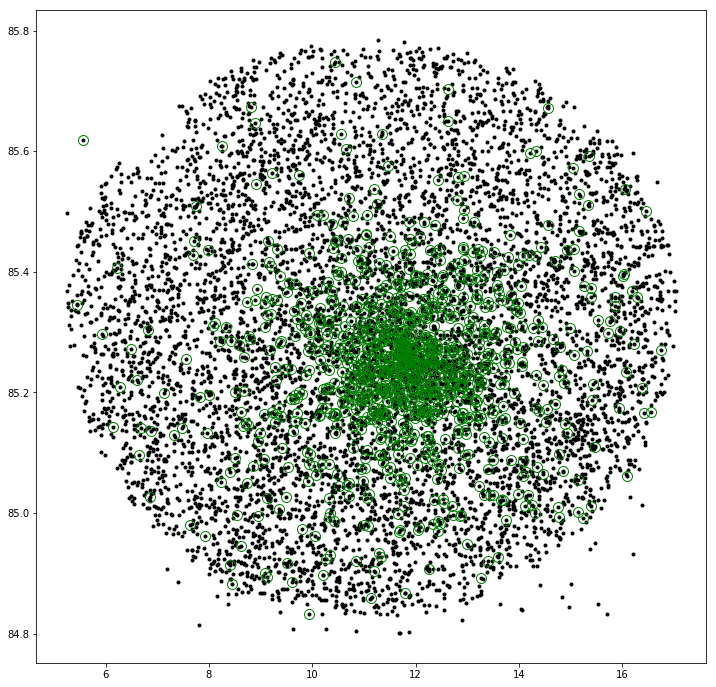

In [16]:
# plot RADEC of selected stars
fig,ax=plt.subplots(figsize=(12,12))
ax.plot(coo_phot.ra,coo_phot.dec,'.k',ms=6)
#ax.plot(coo_gaia.ra,coo_gaia.dec,'.r',ms=1)
ax.plot(coo_members.ra,coo_members.dec,'.g',ms=20,mec='g',mfc='none')

(22.9, 9.1)

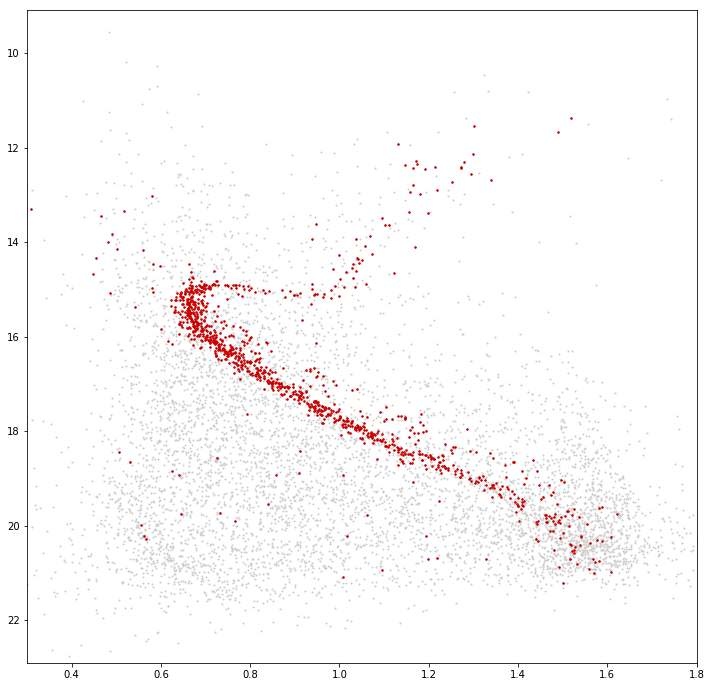

In [17]:
col=tab_phot["B"]-tab_phot["V"]
mag=tab_phot["V"]
col_m=members_phot["B"]-members_phot["V"]
mag_m=members_phot["V"]

fig,ax=plt.subplots(figsize=(12,12))
# CMD of all stars
ax.plot(col,mag    ,'.',ms=2,c='#cccccc')
# only members
ax.plot(col_m,mag_m,'.',ms=3,c="#cc0000")

ax.set_xlim(.3,1.8)
ax.set_ylim(22.9,9.1)